In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
import statsmodels.formula.api as smf
from sqlalchemy import create_engine
from scipy.stats import bartlett
from scipy.stats import levene
from statsmodels.tsa.stattools import acf
from scipy.stats import jarque_bera
from scipy.stats import normaltest
import statsmodels.api as sm
import seaborn as sns; sns.set()

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

weather_df = pd.read_sql_query('select * from weatherinszeged',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [2]:
weather_df.head()

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472,7.389,0.890,14.120,251.000,15.826,0.000,1015.130,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.356,7.228,0.860,14.265,259.000,15.826,0.000,1015.630,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.378,9.378,0.890,3.928,204.000,14.957,0.000,1015.940,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.289,5.944,0.830,14.104,269.000,15.826,0.000,1016.410,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.756,6.978,0.830,11.045,259.000,15.826,0.000,1016.510,Partly cloudy throughout the day.


In [3]:
#chekcing for any missing values:

total_missing = weather_df.isnull().sum().sort_values(ascending=False)
percent_missing = (weather_df.isnull().sum()/weather_df.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total','Percent'])
missing_data

,Total,Percent
dailysummary,0,0.000
pressure,0,0.000
loudcover,0,0.000
visibility,0,0.000
windbearing,0,0.000
windspeed,0,0.000
humidity,0,0.000
apparenttemperature,0,0.000
temperature,0,0.000
preciptype,0,0.000


In [4]:
weather_df['target_variable'] = weather_df.apparenttemperature - weather_df.temperature


In [5]:
weather_df.head()

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary,target_variable
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472,7.389,0.890,14.120,251.000,15.826,0.000,1015.130,Partly cloudy throughout the day.,-2.083
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.356,7.228,0.860,14.265,259.000,15.826,0.000,1015.630,Partly cloudy throughout the day.,-2.128
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.378,9.378,0.890,3.928,204.000,14.957,0.000,1015.940,Partly cloudy throughout the day.,0.000
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.289,5.944,0.830,14.104,269.000,15.826,0.000,1016.410,Partly cloudy throughout the day.,-2.344
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.756,6.978,0.830,11.045,259.000,15.826,0.000,1016.510,Partly cloudy throughout the day.,-1.778


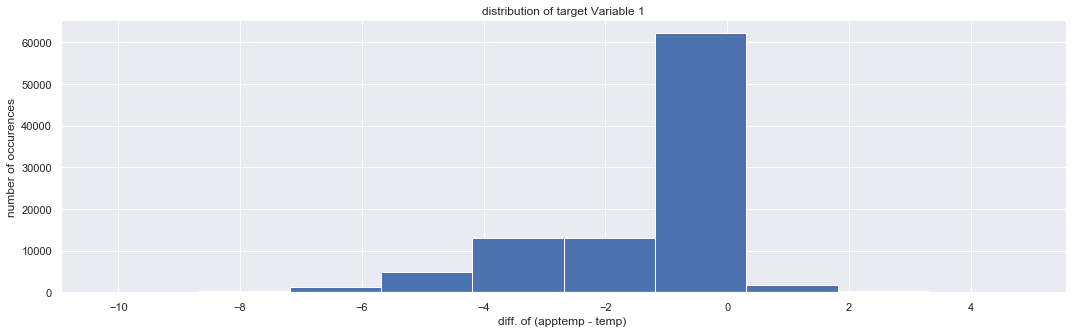

In [6]:
plt.figure(figsize=(18,5))

plt.hist(weather_df.target_variable)
plt.title('distribution of target Variable 1')
plt.xlabel('diff. of (apptemp - temp) ')
plt.ylabel('number of occurences')

plt.show()

In [7]:
X = weather_df[['humidity','windspeed']]

Y = weather_df.target_variable

In [8]:
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        target_variable   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                 1.949e+04
Date:                Wed, 12 Feb 2020   Prob (F-statistic):               0.00
Time:                        19:58:53   Log-Likelihood:            -1.7046e+05
No. Observations:               96453   AIC:                         3.409e+05
Df Residuals:                   96450   BIC:                         3.409e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4381      0.021    115.948      0.0

The R-Squared is 0.288 and the adjusted R-Squared is 0.288. This would be saying that the model explains 28.8% of the variance in changes which leave 71.2% unexplained. This is not satisfactory.

In [9]:
Y = weather_df['target_variable']

weather_df['humidity_windspd'] = weather_df.humidity * weather_df.windspeed

X = weather_df[['humidity','windspeed','humidity_windspd']]

X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        target_variable   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                 1.666e+04
Date:                Wed, 12 Feb 2020   Prob (F-statistic):               0.00
Time:                        20:18:00   Log-Likelihood:            -1.6669e+05
No. Observations:               96453   AIC:                         3.334e+05
Df Residuals:                   96449   BIC:                         3.334e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0839      0.033  

The adjusted R-Squared has increased by about 5% to 34.1%. The model has improved slightly from the previous one.

In [12]:
weather_df['target_variable'] = weather_df.apparenttemperature - weather_df.temperature

In [14]:
X = weather_df[['humidity','windspeed','visibility']]

Y = weather_df.target_variable

In [15]:
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        target_variable   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                 1.401e+04
Date:                Wed, 12 Feb 2020   Prob (F-statistic):               0.00
Time:                        20:43:33   Log-Likelihood:            -1.6938e+05
No. Observations:               96453   AIC:                         3.388e+05
Df Residuals:                   96449   BIC:                         3.388e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5756      0.028     56.605      0.0

model with the lowest AIC and BIC scores is the second model (333400) 

# 2. House Prices Model:

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [17]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_prices_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [18]:
house_prices_df = pd.concat([house_prices_df,pd.get_dummies(house_prices_df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
house_prices_df = pd.concat([house_prices_df,pd.get_dummies(house_prices_df.street, prefix="street", drop_first=True)], axis=1)
dummy_column_names = list(pd.get_dummies(house_prices_df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(house_prices_df.street, prefix="street", drop_first=True).columns)

In [19]:
# Y is the target variable
Y = house_prices_df['saleprice']
# X is the feature set
X = house_prices_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf'] + dummy_column_names]

X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     482.0
Date:                Wed, 12 Feb 2020   Prob (F-statistic):               0.00
Time:                        20:58:16   Log-Likelihood:                -17475.
No. Observations:                1460   AIC:                         3.497e+04
Df Residuals:                    1449   BIC:                         3.503e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.173e+05    1.8e+04     -6.502      0.000   -1.53e+05   -8.19e+04
overallqual  2.333e+04   1088.506     21.430      0.000    2.12e+04    2.55e+04
grlivarea      45.6344      2.468     18.494      0.000      40.794      50.475
garagecars   1.345e+04   2990.453      4.498      0.000    7584.056    1.93e+04
garagearea     16.4082     10.402      1.577      0.115      -3.997      36.813
totalbsmtsf    28.3816      2.931      9.684      0.000      22.633      34.131
mszoning_FV  2.509e+04   1.37e+04      1.833      0.067   -1761.679    5.19e+04
mszoning_RH  1.342e+04   1.58e+04      0.847      0.397   -1.77e+04    4.45e+04
mszoning_RL  2.857e+04   1.27e+04      2.246      0.025    3612.782    5.35e+04
mszoning_RM  9047.7894   1.29e+04      0.702      0.483   -1.62e+04    3.43e+04
street_Pave   151.0376   1.63e+04      0.009      0.993   -3.18e+04    3.21e+04
==============================================================================
Omnibus:                      415.883   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            41281.526
Skew:                          -0.115   Prob(JB):                         0.00
Kurtosis:                      29.049   Cond. No.                     5.53e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.53e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

AIC model is 34970  and BIC model is 35030 
F statistic and its associated p-value are 482 and 0.00 respectively

R-squared 76.7% & 23% of the variance in the target is not explained

In [20]:
house_prices_df['totalsf'] = house_prices_df['totalbsmtsf'] + house_prices_df['firstflrsf'] + house_prices_df['secondflrsf']

house_prices_df['int_over_sf'] = house_prices_df['totalsf'] * house_prices_df['overallqual']

# Y is the target variable
Y = np.log1p(house_prices_df['saleprice'])
# X is the feature set
X = house_prices_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalsf', 'int_over_sf'] + dummy_column_names]

X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     651.8
Date:                Wed, 12 Feb 2020   Prob (F-statistic):               0.00
Time:                        21:01:55   Log-Likelihood:                 570.75
No. Observations:                1460   AIC:                            -1117.
Df Residuals:                    1448   BIC:                            -1054.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           9.8514      0.089    110.698      0.000       9.677      10.026
overallqual     0.1726      0.008     20.699      0.000       0.156       0.189
grlivarea    8.311e-05   1.72e-05      4.839      0.000    4.94e-05       0.000
garagecars      0.0818      0.013      6.307      0.000       0.056       0.107
garagearea   9.684e-05   4.51e-05      2.149      0.032    8.45e-06       0.000
totalsf         0.0003   2.33e-05     11.473      0.000       0.000       0.000
int_over_sf -2.064e-05   2.72e-06     -7.583      0.000    -2.6e-05   -1.53e-05
mszoning_FV     0.4920      0.059      8.344      0.000       0.376       0.608
mszoning_RH     0.3814      0.068      5.597      0.000       0.248       0.515
mszoning_RL     0.4844      0.055      8.845      0.000       0.377       0.592
mszoning_RM     0.3255      0.055      5.876      0.000       0.217       0.434
street_Pave    -0.0010      0.070     -0.014      0.989      -0.138       0.136
==============================================================================
Omnibus:                      489.548   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5085.468
Skew:                          -1.254   Prob(JB):                         0.00
Kurtosis:                      11.793   Cond. No.                     5.22e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.22e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

F statistic and its associated p-value are 651.8 and 0.00 respectively

AIC and BIC of the model are -1117 and -1054 respectively. These values are lower than the ones of the first model


second model has a better goodness of fit than the first model